In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 
import pywt

(CVXPY) Apr 11 10:49:21 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:49:21 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image, 0.15 was largest before
height,width = X.shape #getting height and width of image

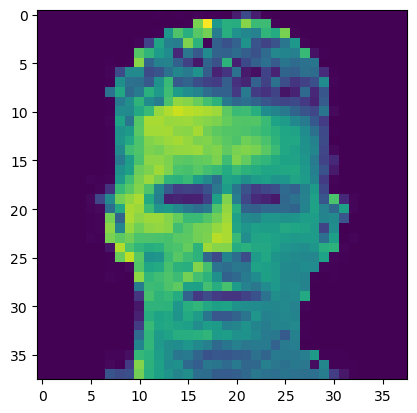

In [4]:
plt.imshow(X)

In [5]:
Y = pywt.dwt2(X, 'db1') #takign wavelet

In [6]:
cA, (cH, cV, cD) = Y

In [7]:
# assinging sections of wavelet transform to form image vector
Y = np.block([
    [cA,cH],
    [cV,cD]
])

In [8]:
y = np.array(Y)

In [9]:
width, height = Y.shape

In [10]:
y = Y.flatten()

In [11]:
dim = y.size

In [12]:
# Removing values below a threshold to create a sparse vector
Yz = Y.copy()
Yz[np.abs(Yz) < 200] = 0.

In [13]:
np.count_nonzero(Yz.real)

121

In [14]:
yz = Yz.flatten()

In [15]:
# Gaussian Sensing Matrix
A = np.random.randint(0,2,size=(dim//2,dim))

In [16]:
b = A@yz

In [17]:
# Optimization on real part
ysparsereal = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [18]:
# Optimization on imaginary part
ysparseimag = cvx.Variable(dim)
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [19]:
ysparse = ysparsereal.value + ysparseimag.value*1j #Joining parts to make a whole result

In [20]:
Ysparse = ysparse.reshape((width,height))

(<matplotlib.image.AxesImage at 0x163275d50>,
 <matplotlib.colorbar.Colorbar at 0x163276390>)

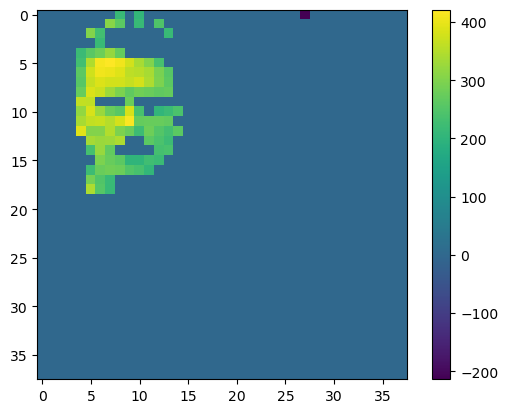

In [21]:
plt.imshow(Ysparse.real), plt.colorbar()

In [22]:
#Choosing sections of wavelet transform to keep formatting the same
LL = Ysparse[:(width//2), :(height//2)]
HL = Ysparse[:(width//2), -(height//2):]
LH = Ysparse[-(width//2):, :(height//2)]
HH = Ysparse[-(width//2):, -(height//2):]

In [23]:
coeffs = (LL, (HL, LH, HH))

In [24]:
# Reconstructing
Xhat = pywt.idwt2(coeffs, 'db1').real

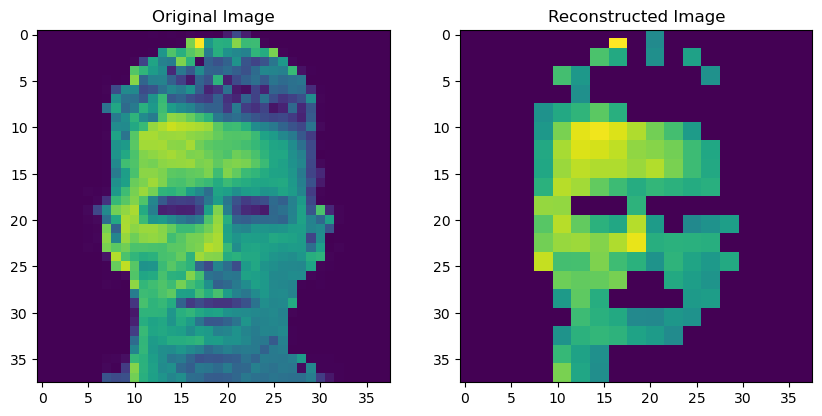

In [25]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

In [26]:
norm_orig = X/255
norm_result = Xhat/255
print(mse(norm_orig, norm_result))
print(mse(X,Xhat))
print(mad(X, Xhat))

0.025841315460221906
1680.3315378009297
20.93970264615757
